# Žica iznad mase

U nastavku je tablica materijala (Ott pp. 243), pa se po potrebi može dopuniti program.
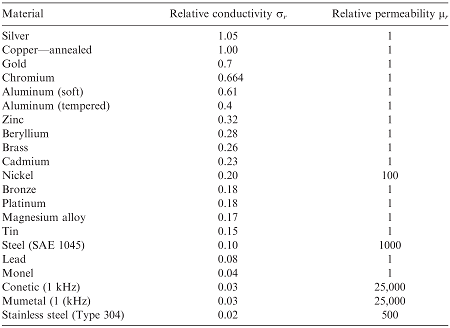

In [1]:
materials = {'silver':'1.05,1', 'copper':'1,1', 'gold':'0.7,1', 'steel':'0.1,1000', 'stainless_steel':'0.02,500', 'mumetal_1kHz':'0.03,25000'} # name, sigma_r, mu_r

Za slučaj kada je $h > 0.75r$ induktivitet žice kružnog presjeka (eng. _external_ _loop_ _inductance_) iznad mase (povratni put struje) može se izračunati,

$L = \frac{\mu_0 \mu_r}{2\pi}\ln{(\frac{4h}{d})}~\mathrm{[H/m]}$,

gdje je $h$ visina iznad mase, a $d$ njegov promjer. Njegova reaktancija je jednaka,

$X_L = 2\pi f L~\mathrm{[\Omega/m]}$.

Otpor žice kružnog presjeka povećava se s frekvencijom uslijed skin-efekta i može se izračunati

$R_{ac}=(3.78d\sqrt{f}+0.26)R_{dc}$,

gdje je $R_{dc}$ otpor žice za istosmjernu struju. Ova jednadžba ne uključuje parametre materijala i točna je s pogreškom od 1% ako je $d\sqrt{f}>0,254$.

In [2]:
def L_wire_above_gnd(h_m,d_m,l_m):    
    # Ott pp. 209
    L = l_m*200*np.log(4*h_m/d_m) # nH/m
    return L/1e9        

In [3]:
def R_wire_above_gnd(d_m,l_m,sigma_r,f):    
    # Ott pp. 211
    sigma_copper = 5.82e7 # S/m
    rho = 1/(sigma_copper*sigma_r)
    Rdc = np.full((1, len(f)), (4*rho/(np.pi*d_m**2)*l_m))          
    Rac = (3.78*d_m*(f)**0.5+0.26)*Rdc.flatten()
    return Rac+Rdc.flatten()

In [4]:
def XL(L,f):    
    XL = 2*np.pi*L*f
    return XL

<IPython.core.display.Javascript object>


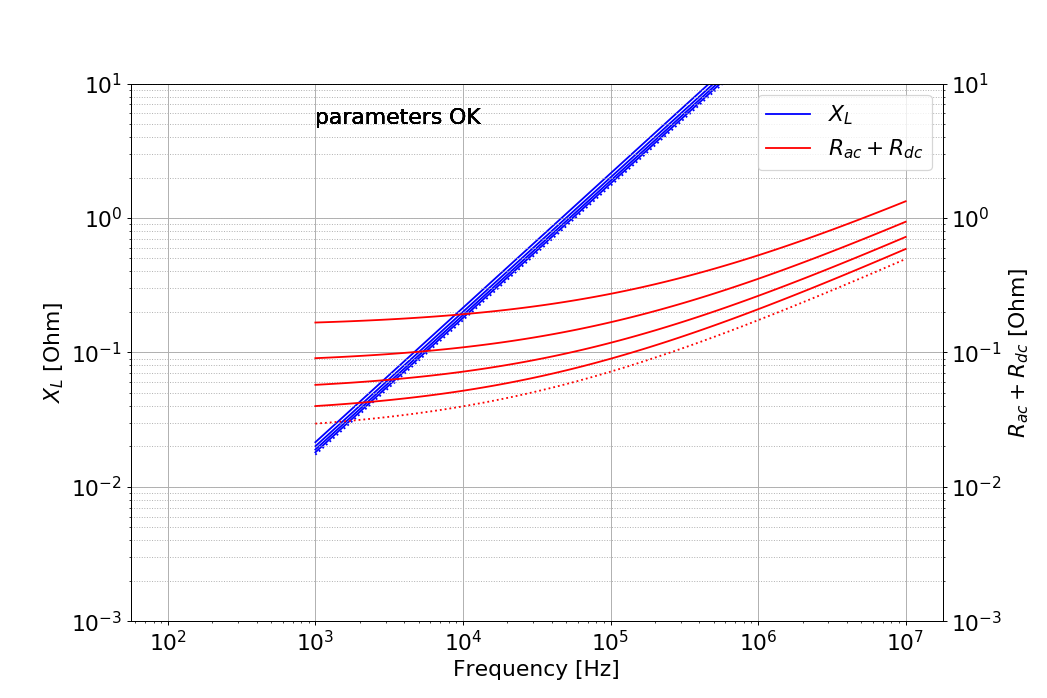

In [42]:
%matplotlib notebook
from ipywidgets import widgets
from ipywidgets import Layout
import numpy as np
import matplotlib.pyplot as plt

style = {'description_width': '150px'}
fmin = widgets.FloatLogSlider(min=1, max=4, step=1, value=1000,description='$f_{min}$ [Hz]:',style=style,layout=Layout(width='75%'), continuous_update=False)
fmax = widgets.FloatLogSlider(min=5, max=10, step=1, value=1e7,description='$f_{max}$ [Hz]:',style=style,layout=Layout(width='75%'), continuous_update=False)
ymin = widgets.FloatLogSlider(min=-4,max=-1, step=1, value=1e-3,description='plot $y_{min}$:',readout_format='.4f',style=style,layout=Layout(width='75%'), continuous_update=False)
ymax = widgets.FloatLogSlider(min=1,max=3, step=1, value=10,description='plot $y_{max}$:',readout_format='.1f',style=style,layout=Layout(width='75%'), continuous_update=False)

r = widgets.FloatSlider(value=0.25,min=0.1,max=1,step=0.05,description='radius [mm]:',readout_format='.2f',style=style,layout=Layout(width='75%'), continuous_update=False)
l = widgets.FloatSlider(value=0.3,min=0.1,max=10,step=0.1,description='length [m]:',readout_format='.1f',style=style,layout=Layout(width='75%'), continuous_update=False)
h = widgets.FloatSlider(value=25,min=1,max=50.0,step=1,description='height [mm]:',readout_format='.1f',style=style,layout=Layout(width='75%'), continuous_update=False)

rb = widgets.RadioButtons(options=['radius', 'length', 'height'], description='sweep var.',disabled=False)
tnov = widgets.Text(value='1',placeholder='',description='no. of values:',style=style,layout=Layout(width='65%'), continuous_update=False)
tmin = widgets.Text(value='0',placeholder='',description='start value:',style=style,layout=Layout(width='65%'), continuous_update=False)
tmax = widgets.Text(value='0',placeholder='',description='stop value (dotted):',style=style,layout=Layout(width='65%'), continuous_update=False)

m = widgets.Dropdown(options=list(materials.keys()),value='copper',description='material:',style=style,layout=Layout(width='50%'))

fig = plt.figure(figsize=(12, 8), dpi= 80, facecolor='w', edgecolor='k')                 
plt.rcParams.update({'font.size': 18})  

axes = plt.gca()    
axes.set_xscale("log")
axes.set_yscale("log")   
plt.sca(axes) 
plt.xlabel('Frequency [Hz]')
plt.ylabel('$X_L$ [Ohm]')        

axes_twin = axes.twinx()   
axes_twin.set_yscale("log")
plt.sca(axes_twin)
plt.xlabel('Frequency [Hz]')
plt.ylabel('$R_{ac}+R_{dc}$ [Ohm]')   

ann_list = []
line_list = []

def f1(fmin, fmax, ymin, ymax, r, l, h, rb, tnov, tmin, tmax, m):    
    
    f = np.logspace(np.log10(fmin), np.log10(fmax), num=100)
   
    sigma_r = float(materials[m].split(',')[0])
    mu_r = float(materials[m].split(',')[1])

    if (int(tnov) > 1) and (float(tmax) > float(tmin)):
        no_lines = int(tnov)
        if rb == 'radius':
            h_m = np.full((1, no_lines), h/1000).flatten()                        
            d_m = np.linspace(2*float(tmin)/1000, 2*float(tmax)/1000, num=int(tnov))
            l_m = np.full((1, no_lines), l).flatten()        
        elif rb == 'length':
            h_m = np.full((1, no_lines), h/1000).flatten()                        
            d_m = np.full((1, no_lines), 2*r/1000).flatten()
            l_m = np.linspace(float(tmin), float(tmax), num=int(tnov))            
        elif rb == 'height':
            h_m = np.linspace(float(tmin)/1000, float(tmax)/1000, num=int(tnov))                        
            d_m = np.full((1, no_lines), 2*r/1000).flatten()
            l_m = np.full((1, no_lines), l).flatten()            
    else:
        no_lines = 1
        h_m = np.array([h/1000])
        d_m = np.array([2*r/1000])
        l_m = np.array([l])        
    
    
    #fig.canvas.draw_idle()    
    #[l.remove() for l in axes.lines]        
    #[l.remove() for l in axes_twin.lines]                    
    
    for i, a in enumerate(ann_list):
        a.remove()
    ann_list[:] = []
    
    if line_list:
        for i, a in enumerate(line_list):
            line = a.pop(0)
            line.remove()    
        line_list[:] = []    
    
    for i in range(no_lines):            
        L = L_wire_above_gnd(h_m[i],d_m[i],l_m[i])  
        R = R_wire_above_gnd(d_m[i],l_m[i],sigma_r,f)   
        XL_calc = XL(L,f)
        if (i == no_lines-1) and (no_lines > 1):
            line = axes.plot(f, XL_calc, linestyle=':', color='b')       
            line_list.append(line)
        else:
            line = axes.plot(f, XL_calc, linestyle='-', color='b')                                               
            line_list.append(line)

        if (i == no_lines-1) and (no_lines > 1):
            line = axes_twin.plot(f, R, linestyle=':', color='r')
            line_list.append(line)
        else:
            line = axes_twin.plot(f, R, linestyle='-', color='r')
            line_list.append(line)
            
        if (h_m[i] < 1.5*d_m[i]):
            ann = plt.annotate('requirement: $h > 0.75r$', xy=(fmin, ymax/2))
            ann_list.append(ann)            
        else:
            ann = plt.annotate('parameters OK', xy=(fmin, ymax/2))
            ann_list.append(ann)
            
        plt.sca(axes) 
        plt.grid(axis='both')               
        plt.ylim(bottom = ymin, top = ymax) 

        plt.sca(axes_twin) 
        plt.grid(True,which="both",ls=":")
        plt.ylim(bottom = ymin, top = ymax)                         


    linesL = axes.get_lines() + axes_twin.get_lines()      
    legend1 = plt.legend([linesL[i] for i in [0,no_lines]], ["$X_L$","$R_{ac}+R_{dc}$"], loc=1)                                    
             
out = widgets.interactive_output(f1, 
                                 {'fmin': fmin, 'fmax': fmax, 'ymin': ymin, 'ymax': ymax, 
                                  'r': r, 'l': l, 'h': h, 
                                  'rb': rb, 
                                  'tnov': tnov, 'tmin': tmin, 'tmax': tmax, 'm': m})

tab1 = widgets.VBox(children=[fmin,fmax, ymin, ymax])
tab2 = widgets.VBox(children=[r,l,h,widgets.HBox(children=[rb,widgets.VBox(children=[tnov,tmin,tmax])]),m])

tab = widgets.Tab(children=[tab1, tab2])
tab.set_title(0, 'plot')
tab.set_title(1, 'parameters')


widgets.VBox([tab, out])

In [41]:
line_list

[[],
 [],

In [31]:
ivo = line_list[0]

In [38]:
plt.Line2D.remove(0)

AttributeError: 'int' object has no attribute '_remove_method'